В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Mounted at /content/drive
Area under ROC score on Training dataset: 0.88%
F1 score: 0.62%


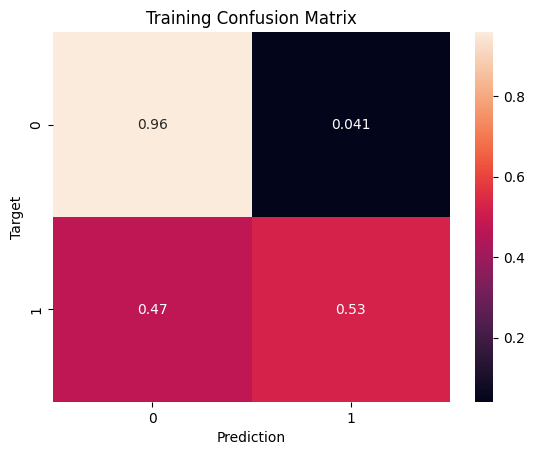

Area under ROC score on Validation dataset: 0.88%
F1 score: 0.64%


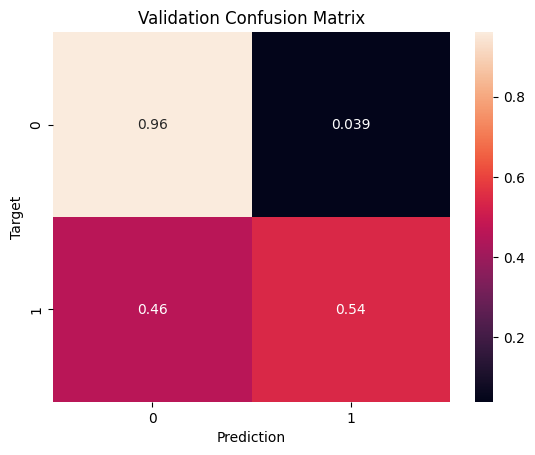

['churn_pred_pipeline.joblib']

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from google.colab import drive
drive.mount('/content/drive')

bank_train_df = pd.read_csv("drive/MyDrive/machine_learning_for_people/kaggle_competition/bank_customer_churn_prediction/train.csv", index_col=0)
bank_test_df = pd.read_csv("drive/MyDrive/machine_learning_for_people/kaggle_competition/bank_customer_churn_prediction/test.csv", index_col=0)
submission_df = pd.read_csv('drive/MyDrive/machine_learning_for_people/kaggle_competition/bank_customer_churn_prediction/sample_submission.csv', index_col=0)

train_df, val_df = train_test_split(bank_train_df, test_size=0.2, random_state=42)

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Визначення числових і категоріальних колонок
numeric_cols = train_inputs.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include=['object']).columns.tolist()

numeric_cols = [col for col in numeric_cols if col !='CustomerId']
categorical_cols = [col for col in categorical_cols if col != 'Surname']

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Тренуємо модель
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    preds_proba = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, preds_proba)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    f1 = f1_score(targets, preds)
    print("F1 score: {:.2f}%".format(f1))
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'churn_pred_pipeline.joblib')

In [3]:
# Завантажуємо модель для перевірки
model_pipeline_loaded = joblib.load('churn_pred_pipeline.joblib')

In [4]:
model_pipeline_loaded

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression())])

Зібрано усі кроки розвʼязку задачі разом з використанням sklearn.Pipeline та збережено у файл 'churn_pred_pipeline.joblib' для подальшого використання.

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Model with Polynomial Features:
Area under ROC score on Training dataset: 0.92%
F1 score: 0.69%


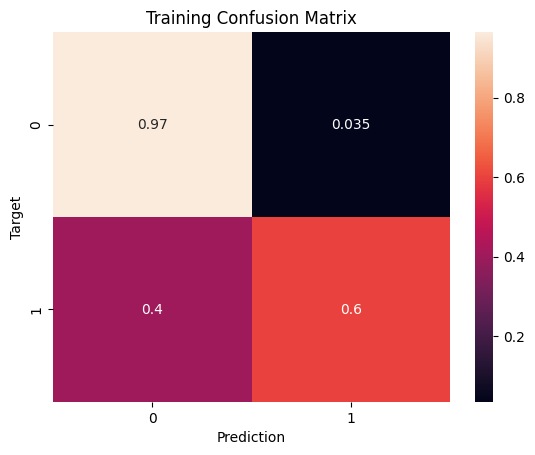

Area under ROC score on Validation dataset: 0.91%
F1 score: 0.69%


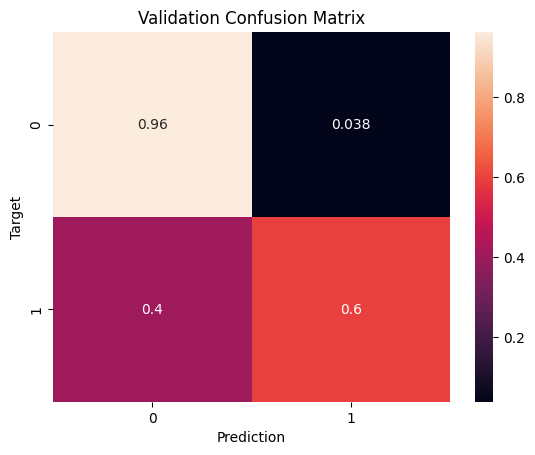

In [5]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Додавання Polynomial Features у числовий трансформер
degree = 2
numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=degree, include_bias=False))  # Генерація поліноміальних ознак
])

# Трансформер для категоріальних даних залишається незмінним
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінований препроцесор для числових і категоріальних колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),  # Числові дані з Polynomial Features
        ('cat', categorical_transformer, categorical_cols)  # Категоріальні дані
    ]
)

# Створення кінцевого пайплайну
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Навчання моделі
model_pipeline_poly.fit(train_inputs, train_targets)

# Оцінка на тренувальному і валідаційному наборах
print("Model with Polynomial Features:")
train_preds_poly2 = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Training')
val_preds_poly2 = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')

AUROC на тренувальному наборі 0.92, на валідаційному 0.91. Це означає, що модель добре розрізняє класи (у нашому випадку – клієнтів, які залишають банк, і тих, хто залишається).

Confusion Matrix показує схожі значення для тренувального та валідаційного наборів, що свідчить про стабільність моделі.

Overfitting зазвичай проявляється, коли модель добре працює на тренувальних, але погано на валідаційних даних. У нашому випадку AUROC майже однаковий (0.92 vs 0.91), тобто значного оverfitting не спостерігається.

Underfitting не спостерігається.

Модель добре генералізує на нові дані.


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Model with Polynomial Features:
Area under ROC score on Training dataset: 0.93%
F1 score: 0.74%


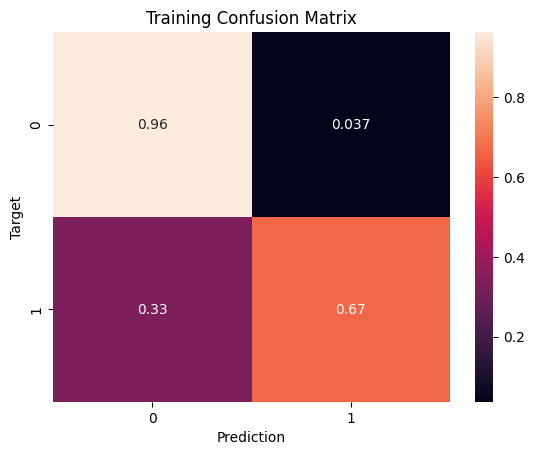

Area under ROC score on Validation dataset: 0.92%
F1 score: 0.72%


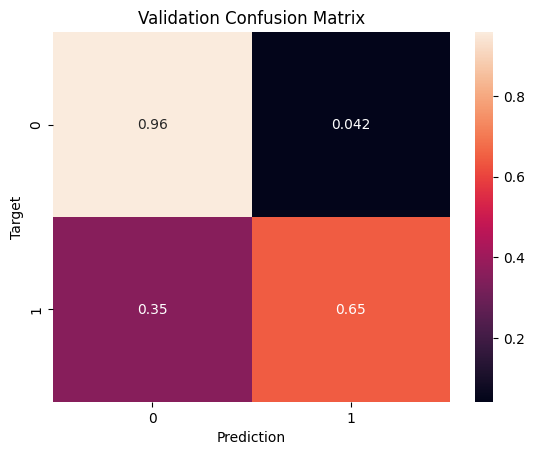

In [6]:
#Ствроюємо новий пайплайн, поліномальні ознаки згенеруємо до степені 4.
degree = 4
numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=degree, include_bias=False))  # Генерація поліноміальних ознак
])

# Трансформер для категоріальних даних залишається незмінним
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінований препроцесор для числових і категоріальних колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),  # Числові дані з Polynomial Features
        ('cat', categorical_transformer, categorical_cols)  # Категоріальні дані
    ]
)

# Створення кінцевого пайплайну
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Навчання моделі
model_pipeline_poly4.fit(train_inputs, train_targets)

# Оцінка на тренувальному і валідаційному наборах
print("Model with Polynomial Features:")
train_preds4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Training')
val_preds4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Validation')


Порівняно з попереднім варіантом (поліноміальні ознаки до степеня 2), AUROC зріс із 0.92 до 0.93 на тренувальному наборі та з 0.91 до 0.92 на валідаційному наборі. Це свідчить про покращення якості класифікації.

F1 Score також покращився, це вказує на покращення якості передбачення.

Оскільки різниця між AUROC і F1 Score для тренувального та валідаційного наборів незначна, це означає, що модель генералізує добре і її можна використовувати для передбачень.

Confusion Matrix показує, що модель досить точно класифікує об'єкти класу 0 (96%), але менш точно класифікує об'єкти класу 1 (67%) в тренувальному наборі та відповідно об'єкти класу 0 (96%) і об'єкти класу 1 (65%) у валідаційному наборі.





Зробимо submission моделі зі степенем 4 на Kaggle.

In [7]:
# Робимо пердбачення за допомогою моделі зі степенем 4
test_preds_proba = model_pipeline_poly4.predict_proba(bank_test_df)[:, 1]


In [8]:
# Додавання результатів у DataFrame submission_df
submission_df['Exited'] = test_preds_proba

In [9]:
# Збереження результатів у CSV-файл
submission_df.to_csv('submission_with_poly.csv')

In [10]:
submission_df2 = pd.read_csv('submission_with_poly.csv')

In [11]:
submission_df2

,id,Exited
0,15000,0.074068
1,15001,0.019240
2,15002,0.067022
3,15003,0.417894
4,15004,0.026967
...,...,...
9995,24995,0.013128
9996,24996,0.012469
9997,24997,0.005429
9998,24998,0.128830


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Завантаження даних
regression_df = pd.read_csv('drive/MyDrive/machine_learning_for_people/HW.2.2/regression_data.csv')

# Розділення на ознаки та цільову змінну
X = regression_df.drop(columns=['target'])
y = regression_df['target']

# Розділення на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=5, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Передбачення
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Оцінка моделі
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('train RMSE:', train_rmse, 'train R2:', train_r2)
print('test RMSE:', test_rmse, 'test R2:', test_r2)

train RMSE: 7.048392743800196e-13 train R2: 1.0
test RMSE: 29.433496525993476 test R2: 0.6286727837799393


Результати:

Train RMSE: 7.048392743800196e-13
У нашому випадку RMSE на тренувальному наборі наближається до нуля, що означає, що модель практично ідеально підходить до тренувальних даних.


Таке значення є ознакою overfitting (перенавчання) — модель "запам'ятала" навіть шум або особливості тренувальних даних, які не є узагальненими для нових даних.


Значення R2= 1.0 вказує, що модель на тренувальних даних здатна повністю пояснити варіацію цільової змінної.
Це також вказує на перенавчання.

Test RMSE: 29.43
RMSE для тестових даних значно більше, ніж для тренувальних. Це свідчить про те, що модель працює погано на невідомих даних.

Test R2: 0.63
Значення R2 на тестовому наборі 0.63 вказує на те, що модель пояснює 63% варіації цільової змінної на тестових даних.
Модель не дуже добре генералізує на нові дані.

Висновки:
Overfitting: Модель дуже добре навчається на тренувальних даних (практично ідеальні метрики), але погано працює на тестових даних. Тобто спостерінається перенавчання, модель занадто "запам'ятовує" дані тренування і не може добре передбачати на нових даних.


**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [20]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [21]:
# Створюємо моделі
from sklearn.linear_model import Lasso, Ridge, ElasticNet
models = [
    Ridge(),
    Lasso(),
    Lasso(alpha=0.5),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [22]:
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = root_mean_squared_error(y_train, y_train_pred)
    test_metrics = root_mean_squared_error(y_test, y_test_pred)

    return dict(train_RMSE=train_metrics, test_RMSE=test_metrics)

In [24]:
poly = PolynomialFeatures(degree=20)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [25]:
X_train_poly.shape

(103, 53130)

In [26]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly, y_train)
    eval_results  = evaluate_model(model, X_train_poly, y_train, X_test_poly, y_test)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train_RMSE': 32.582352198481345, 'test_RMSE': 9034.946659153928}

Lasso(): {'train_RMSE': 2.313505449570354, 'test_RMSE': 68.31879121877043}

Lasso(alpha=0.5): {'train_RMSE': 1.321526191174596, 'test_RMSE': 18.21850540279577}

ElasticNet(): {'train_RMSE': 10.159852342199374, 'test_RMSE': 1526.8209205681153}

ElasticNet(alpha=0.5): {'train_RMSE': 7.7417320342064295, 'test_RMSE': 1083.4024678459548}



Найкращою моделлю для генералізації з наших результатів є Lasso (alpha = 0.5).

Lasso дає найкращі результати по test RMSE порівняно з іншими моделями, що свідчить про її здатність до гарної генералізації на нових, невідомих даних навіть при використанні високих степеней поліноміальних ознак.

Вона зменшує перенавчання завдяки регуляризації L1, яка зменшує вплив менш важливих ознак, накладаючи штраф на величину коефіцієнтів (коефіцієнти для деяких ознак можуть бути зведені до нуля). Це допомагає зменшити складність моделі та уникнути перенавчання.
